# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

###### Таблица содержит 23699 строк, то есть 23699 объявлений о продаже квартиры, и 22 столбца. У некоторых столбцов имеются пропущеные значения, их необходимо будет рассмотреть и обработать при необходимости.

### Шаг 2. Предобработка данных

In [65]:
# проверим столбец is_apartment, какие значения он имеет
data['is_apartment'].value_counts()
# вероятнее всего пропущенные значения это те же False, поэтому заменим их соответственно на False
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

In [66]:
#тоже самое проделаем с балконами
data['balcony'].value_counts()
#пропущенное значение так же вероятнее всего означает что балкона нет
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].value_counts()

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

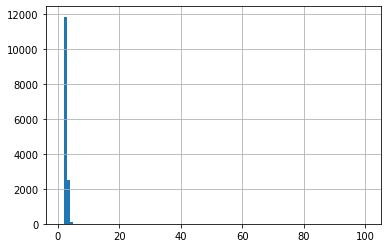

In [67]:
# из общего инфо по таблице мы знаем что в графе ceiling_height есть пропущенные значения, их необходимо заполнить, так как по 
# данному столбцу мы будем проводить исследование
# проверим на гистограмме распределение высоты потолков
data['ceiling_height'].hist(bins=100)
# видно что единичные значения достигают 100 метров, что в принципе невозможно, даже выше 4 метров найти 
# апартаменты практически невозможно, значения меньше 2 метров так же нереальны, от них можно избавиться

In [68]:
data.drop(data[data['ceiling_height'] > 6].index, inplace=True)
data.drop(data[data['ceiling_height'] < 2].index, inplace=True)
data.reset_index(drop=True,inplace=True)

In [69]:
print(data['ceiling_height'].median())
data.pivot_table(index = 'floors_total', values='ceiling_height')

2.65


,ceiling_height
floors_total,
1.0,2.740000
2.0,2.788962
3.0,2.896533
4.0,2.956358
5.0,2.708221
6.0,3.074013
7.0,2.946960
8.0,2.856818
9.0,2.581166


In [70]:
# из сводной таблицы видно, что медианное значение в целом подходит для дома любой этажности
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].count()

23667

In [71]:
data['locality_name'].isnull().mean()

0.002070393374741201

In [72]:
# столбец с населенным пунктом понадобиться нам для исследования, пропущенные значения составляют всего 0.2% от общего числа
# от этих строк можно просто избавиться
data.dropna(subset = ['locality_name'],inplace=True)
data.reset_index(drop=True,inplace=True)

In [73]:
# проверим пропущенные значения в столбце "кол-во этажей в доме"
data['floors_total'].isnull().mean()

0.0035989499534253536

In [74]:
# всего 0.36% пропущенных значений, поступим по аналогии с населенным пунктом
data.dropna(subset = ['floors_total'],inplace=True)
data.reset_index(drop=True,inplace=True)
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23528,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,...,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23529,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.0,4,False,...,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23530,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.7,1,False,...,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23531,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,False,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23532,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.50,5.0,12.3,1,False,...,9.00,0.0,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
len(data[(data['cityCenters_nearest'].isnull())]) / len(data)

0.23328942336293715

In [76]:
len(data[(data['cityCenters_nearest'].isnull()) & (data['locality_name'] == 'Санкт-Петербург')]) / len(data)
# при общей доли отсутсвующих значений в столбце расстояния до центра в 23%, всего отсутствующих значений в самом
# Санкт-Петербурге - 0.2%, данные пропуски можно отсавить, т.к если из заполнять, например, медианой, то на нее сильно повлияет
# как раз большое количество квартир без пропусков, расположенных в самом Санкт-Петербурге

0.002549611184294395

In [77]:
data['kitchen_area'].isnull().sum()

2216

In [78]:
# логично, что в квартире-студии площадь кухни = 0,так как в планировке нет чётких границ
# поступим соответственно: заменим в таких квартирах значение на 0 
data.loc[data['studio'] == True, 'kitchen_area'] = 0

In [79]:
# во всех остальных случаях заменим на медианное значение. Проверим на отсутствие пропусков 
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

In [80]:
data['kitchen_area'].isnull().sum()

0

In [81]:
data['living_area'] = data['living_area'].fillna(data['living_area'].median())

In [82]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

In [83]:
len(data[(data['days_exposition'].isnull())])

3165

In [84]:
# Проверим на наличие дубликатов
data.duplicated().sum()

0

### Вывод

* Я произвёл замену на медианное значение в пропущенных строках, где это посчитал уместным. Например высота этажей и площадь кухни.
* Если процент пропущенных значений от общего числа значений крайне мал, то такие строки я удалял из таблицы. ( во всех  случаях проценты был менее единицы)
* Те значения, которые я не тронул, например расстояние до ближайшего парка или водоёма, число парков в радиусеу 3 км., число фотографий в объявлении - не понадобятся нам для дальнейших расчётов, их можно оставить без изменений.
* Пропущенные значения, где указанно, сколько дней провисело объявление, я оставил без изменений, полагаю, что они означают, что объявление о продаже все еще не закрыто и квартира не продана.
* Так же я изменил тип столбца first_day_exposition на datetime для дальнейшей работы с датой и временем.

### Шаг 3. Посчитайте и добавьте в таблицу

In [85]:
# расчет и добавление в таблицу столбца цены за квадратный месяц
data['price_per_sqm'] = round(data['last_price'] / data['total_area'],1)

In [86]:
# добалвение дня недели, месяца и года публикации объявления
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [87]:
# Напишем функцию, которая поделит на 3 категории квартиры, в завимиости от того, на каком этаже та находится.
def floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
# Добавим столбец в табоицу, применив функцию
data['floor_group'] = data.apply(floor, axis =1)

In [88]:
data['floor_group'].value_counts()

другой       17301
последний     3326
первый        2906
Name: floor_group, dtype: int64

In [89]:
# Расчет и добавление в таблицу столбца со значением соотношения жилой площади к общей площади
data['ratio_living_area'] = round(data['living_area'] / data['total_area'], 2)

In [90]:
# Расчет и добавление в таблицу столбца со значением соотношения площади кухни к общей площади
data['ratio_kitchen_area'] = round(data['kitchen_area'] / data['total_area'], 2)

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

count    23533.000000
mean        60.334116
std         35.673505
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


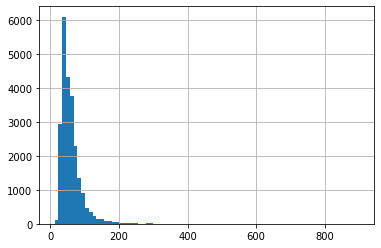

In [91]:
print(data['total_area'].describe())
data['total_area'].hist(bins=80)
# данные вынлядят нормально, средняя площадь в 60, и большентво квартир около 50кв.м., даже квартира в 900 кв.м вполне реальна

count        23533.0
mean       6542469.0
std       10917709.1
min          12190.0
25%        3400000.0
50%        4650000.0
75%        6799000.0
max      763000000.0
Name: last_price, dtype: float64


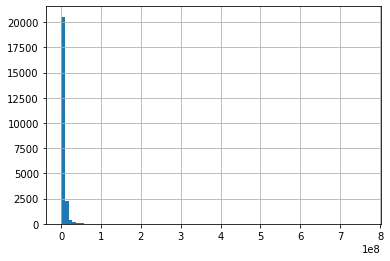

In [92]:
print(round(data['last_price'].describe(), 1))
data['last_price'].hist(bins=80)

In [93]:
# проверим что за значения выбиваются из  общей картины
data['last_price'].sort_values(ascending = False).head(15)

12882    763000000.0
19408    420000000.0
14605    401300000.0
1430     330000000.0
15548    300000000.0
22671    289238400.0
16354    245000000.0
13656    240000000.0
5852     230000000.0
8845     190870000.0
19733    180000000.0
19025    160000000.0
2526     159984000.0
16388    159000000.0
1021     155000000.0
Name: last_price, dtype: float64

In [94]:
data.loc[data['last_price'].isin(['763000000'])]
# даже кавартира с максимальной ценой не похожа на ошибку для 400кв.м и 7 комнат.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,weekday,month,year,floor_group,ratio_living_area,ratio_kitchen_area
12882,19,763000000.0,400.0,2017-09-30,7,2.65,10.0,250.0,10,False,...,3.0,756.0,33.0,1907500.0,5,9,2017,последний,0.62,0.02


In [95]:
data['last_price'].sort_values().head()
# а вот квартира в цену 12190 явно ошибка

8738      12190.0
14809    430000.0
17339    430000.0
16167    440000.0
16112    450000.0
Name: last_price, dtype: float64

In [96]:
data.drop(data[data['last_price'] == 12190].index, inplace=True)
data.reset_index(drop=True,inplace=True)

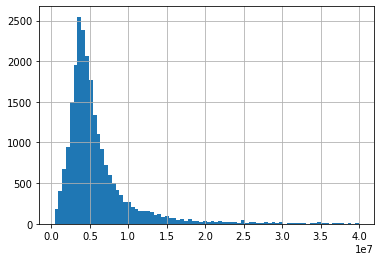

In [97]:
# что бы лучше рассмотреть разброс цен на гистограмме, зададим ограничение
data.query('last_price < 40000000')['last_price'].hist(bins=80)
# в основном квартиры идут по цене 3-5млн, весьма похоже на правду

count    23532.000000
mean         2.070967
std          1.078877
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


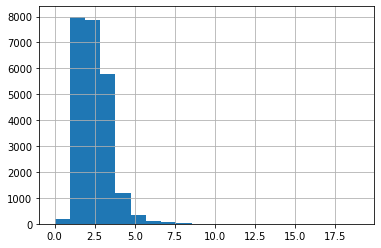

In [98]:
print(data['rooms'].describe())
data['rooms'].hist(bins=20)

In [99]:
# благодряа гистограмме обнаружились нулевые значения, проверим сколько их и взглянем на некоторые из них
print(len(data.query('rooms == 0')))
data.query('rooms == 0').sample(5)

193


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,weekday,month,year,floor_group,ratio_living_area,ratio_kitchen_area
15502,4,3499000.0,25.00,2019-04-05,0,2.80,14.0,17.00,13,False,...,0.0,NaN,NaN,139960.0,4,4,2019,другой,0.68,0.00
17505,12,3150000.0,22.00,2017-05-20,0,2.65,16.0,15.00,14,False,...,1.0,851.0,515.0,143181.8,5,5,2017,другой,0.68,0.00
17903,11,3500000.0,31.00,2019-04-17,0,2.65,25.0,30.00,2,False,...,1.0,170.0,NaN,112903.2,2,4,2019,другой,0.97,0.00
6318,5,2820000.0,27.81,2018-08-09,0,2.70,25.0,17.85,5,False,...,NaN,NaN,131.0,101402.4,3,8,2018,другой,0.64,0.00
15330,0,2200000.0,27.00,2017-01-01,0,2.65,25.0,15.00,5,False,...,3.0,865.0,336.0,81481.5,6,1,2017,другой,0.56,0.33


In [100]:
len(data.query('rooms == 0 and studio == True'))
# практически все строки где количество комнат равно 0 - это студии, значит это не ошибка в даннных

135

count    23532.000000
mean         2.696972
std          0.221422
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64


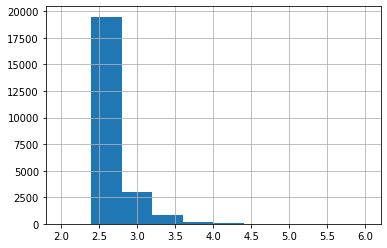

In [101]:
print(data['ceiling_height'].describe())
data['ceiling_height'].hist(bins=10)
# на этапе предобработки мы избавились от аномальных занчений, поэтому гистограмма выглядит нормально

count    20367.000000
mean       180.777287
std        219.796200
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


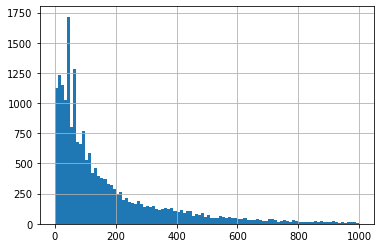

In [102]:
print(data['days_exposition'].describe())
data['days_exposition'].hist(bins=100, range=(0,1000))

In [103]:
data['days_exposition'].value_counts().head(10)
# График имеет аномлаьные пики на 45 и 60 днях, веротяно это связано с условиями рамещени объявлений, которые автоматически 
# снимаются через определенный срок,если они не актиывны, избавиться от них - это потерять часть данных, в любом случае есть
# кваритры которые продаются за такой период. По той же причине неверно будет заменть их меданой или средним, оставим как есть.

45.0    879
60.0    538
7.0     233
30.0    208
90.0    200
4.0     174
3.0     157
5.0     152
14.0    146
9.0     142
Name: days_exposition, dtype: int64

(-50, 600)

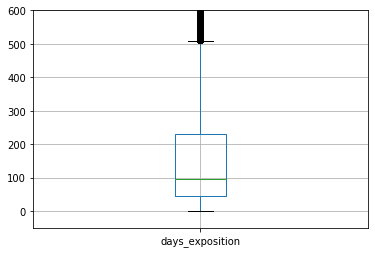

In [104]:
data.boxplot(column ='days_exposition')
plt.ylim(-50,600)
# мы уже знаем, что половина всех квартир продается менее чем за 96 дней(медиана). Необычно долгим сроком продажи квартиры
# можно считать краницу верхнего "уса" ~510 дней. Нижний "ус" упирается в 0. Полагаю, что интуитивно можно считать,
# что продажа прошла быстро, если срок продажи сосатвлял меньше 7 дней.

* Мы уже знаем, что половина всех квартир продается менее чем за 96 дней(медиана), то есть 3 месяца. Необычно долгим сроком продажи квартиры можно считать краницу верхнего "уса" ~510 дней, практически полтора года ожидания, очень долгий срок. Нижний "ус" упирается в 0, и четверть всех квартир продается менее чем за 45 дней. Я думаю, что если срок продажи квартиры составляет менее месяца, то его можно считать аномалаьно короткими. Возможно эти сделки следует проверить на предмет мошенничества.
* В целом, средней квартиру можно считаь, если: ее общая площадь состалвяет 55кв.м, цена в районе 5млн. рублей, квартира двухкомнатная с высотой потолков 2.65м.

##### От ошибочных и выбивающихся значений я избавился на моменте предобработки данных, с комментариями.

0.6537800698098928

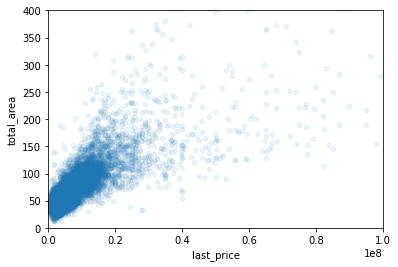

In [105]:
data.plot(x = 'last_price', y = 'total_area', kind = 'scatter', alpha=0.08)
plt.xlim(0,100000000)
plt.ylim(0,400)
data['last_price'].corr(data['total_area'])

0.36333543435947874

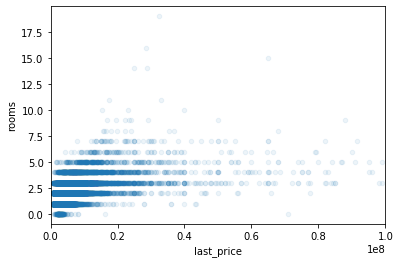

In [106]:
data.plot(x = 'last_price', y = 'rooms', kind = 'scatter', alpha=0.08)
plt.xlim(0,100000000)
data['last_price'].corr(data['rooms'])

In [107]:
data.pivot_table(index='locality_name', values= 'cityCenters_nearest')
# эту талицу я построил что бы понять, что расстоняие идет от центра Санкт-Петербурга, а не центрального места в котором продают

,cityCenters_nearest
locality_name,
Зеленогорск,54617.583333
Колпино,32113.771513
Красное Село,30046.144509
Кронштадт,49180.265957
Ломоносов,50739.969697
Павловск,33206.921053
Петергоф,35468.925373
Пушкин,28745.375000
Санкт-Петербург,11588.363817


-0.20643893269285069

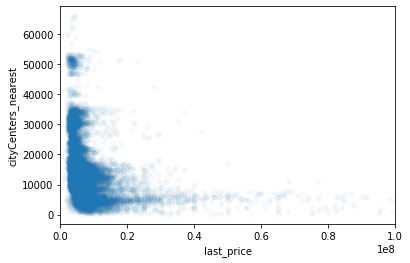

In [108]:
data.plot(x = 'last_price', y = 'cityCenters_nearest', kind = 'scatter', alpha=0.03)
plt.xlim(0,100000000)
data['last_price'].corr(data['cityCenters_nearest'])

In [109]:
len(data.query('cityCenters_nearest < 15000')) / len(data)

0.5001274859765426

In [110]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

(-50, 7500000)

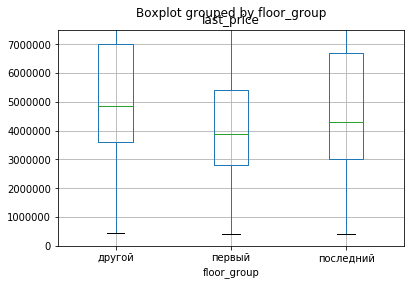

In [111]:
data.boxplot(column ='last_price',by ='floor_group')
plt.ylim(-50,7500000)

(0, 7500000)

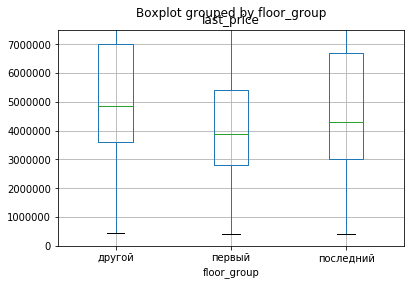

In [112]:
data.boxplot(column ='last_price',by ='floor_group')
plt.ylim(0,7500000)

(0, 15000000)

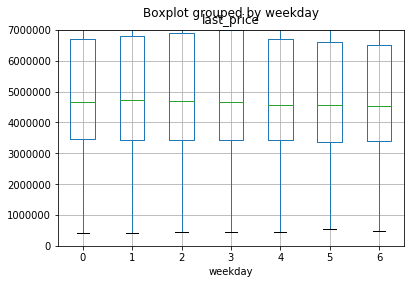

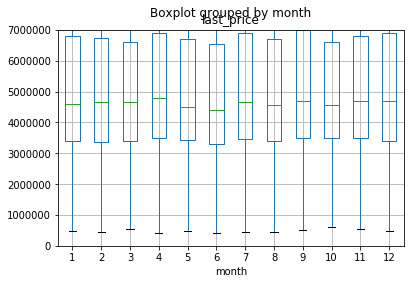

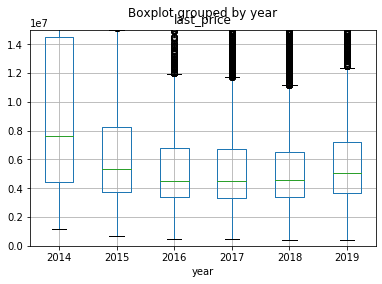

In [113]:
for column in ['weekday', 'month', 'year']:
    data.boxplot(column = 'last_price' ,by = column)
    plt.ylim(0,7000000)
plt.ylim(0,15000000)

* Как и сделовало ожидать, самый большой коэффициент корреляции между площадью квартиры и ее стоимостью - 0.65. 
* Зависимоть же цены от количества комнат обладает сравнительно небольшой корреляцией, всего 0.36. Скорее всего это из-за квартир, у которых количество комнат превышает 6, так как такие картирые сложнее продать, а значит и спрос на них ниже, а соответственно и цена.
* Зависисмоть цены на расстояние от центра города имеет отрицателтную корелляци, что тоже вполне очевидно, однако значение так же сравнительно небольшое, но из графика видно, что, не считая выбросов, квартиры стоимтостью более 20.мл не находят от центра дальше чем на ~15км., а это половина всех объявлений.
* Что бы оценить зависимтость цены(количественная переменная) от этажа и периода публикации переменной(категориальные переменные) я построил графики типа boxplot. По ним можно сделать вывод, что день, месяц и год публикации заявления не cbkmyj зависят от того, за сколько будет продана квартира. Выделяется только 2014 год. Квартиры выставленные в этот период в среднем  на 2млн. с лишним дороже квартир 2015 года, и на 3млн. дороже квартир последующих годов. Так же видно что квартиры, которые находятся на 1 этаже самые дешевые, а квартиры на любом другом этаже кроме последнего в среднем на 1млн. дороже.

In [114]:
data_price_per_sqm = data.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'mean'])
data_price_per_sqm.columns = ['count', 'mean']
data_price_per_sqm.sort_values('count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15631,114857.551436
посёлок Мурино,518,85645.902703
посёлок Шушары,439,78551.343964
Всеволожск,398,68654.475628
Пушкин,369,103125.818157
Колпино,338,75424.581953
посёлок Парголово,327,90175.915291
Гатчина,306,68757.679085
деревня Кудрово,299,92473.546488


#### Из данной таблицы видно, объектами с самой высокой ценой за кв.м являются Санкт-Петербург, Пушкино, Деревня Кудрово и посёлок Парголово. Самые дешевые в Всеволжске, Гатчичина и Выборге(в 2 раза меньше чем в СПб.) Интересным фактом является то, что в городе Пушкин цена за кв.м почти такая же как в самом Санкт-Петербурге. Возможно это довольно богатый город в ленинградском районе, где проживает и отдыхает элита. Деревня Кудрово так же не сильно отстает.

In [115]:
# создаем столбец с расстоянием до центра в км.
data['spb_km'] = round(data['cityCenters_nearest'] / 1000, 0)

Text(0, 0.5, 'цена умноженная на 10 млн')

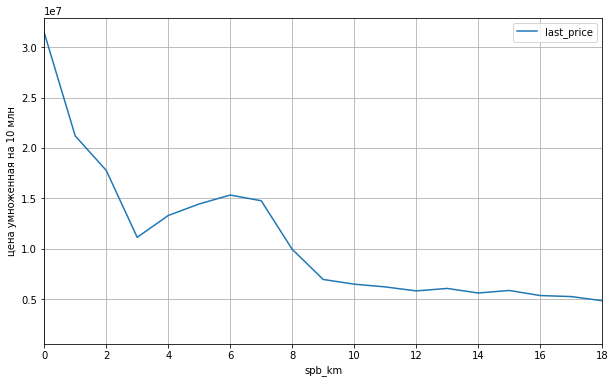

In [116]:
data.pivot_table(index = 'spb_km', values = 'last_price').plot(grid = True, figsize = (10,6))
plt.xlim(0,18)
plt.ylabel('цена умноженная на 10 млн')

In [117]:
round(data.pivot_table(index = 'spb_km', values = 'last_price',),2).head(10)

,last_price
spb_km,
0.0,31449115.85
1.0,21206720.83
2.0,17788319.61
3.0,11146436.17
4.0,13309090.71
5.0,14455995.62
6.0,15338418.39
7.0,14775152.59
8.0,9961374.21


#### С 7 по 9 км происходит падение средней цены, после которого каких либо резких скачков и роста уже не наблюдается. Возьмем за границу центра 8км.

In [118]:
city_center = data.query('spb_km <= 8')
spb_data = data.query('locality_name == "Санкт-Петербург"')

In [119]:
for column in ['total_area', 'last_price', 'rooms','ceiling_height']:
    print(round(city_center[column].describe(),1))

count    4107.0
mean       90.3
std        58.9
min        12.0
25%        55.0
50%        76.0
75%       107.0
max       900.0
Name: total_area, dtype: float64
count         4107.0
mean      14181998.8
std       23617642.8
min        1600000.0
25%        6450000.0
50%        8950000.0
75%       13900000.0
max      763000000.0
Name: last_price, dtype: float64
count    4107.0
mean        2.8
std         1.4
min         0.0
25%         2.0
50%         3.0
75%         3.0
max        19.0
Name: rooms, dtype: float64
count    4107.0
mean        2.9
std         0.4
min         2.0
25%         2.6
50%         2.8
75%         3.1
max         6.0
Name: ceiling_height, dtype: float64


#### Для центра Санкт-Петербурга средней крватирой можно считать ту, площадь которой составояет 76м.кв, цена составаляет 9млн. рублей, квартира является трехкомнатной со редней высотой потолков 2.8м.

In [120]:
print(spb_data['rooms'].describe())
city_center['rooms'].describe()

count    15631.000000
mean         2.172798
std          1.148820
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


count    4107.000000
mean        2.758948
std         1.426846
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64

count    15631.000000
mean         2.172798
std          1.148820
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
count    4107.000000
mean        2.758948
std         1.426846
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64


(-50, 70000000)

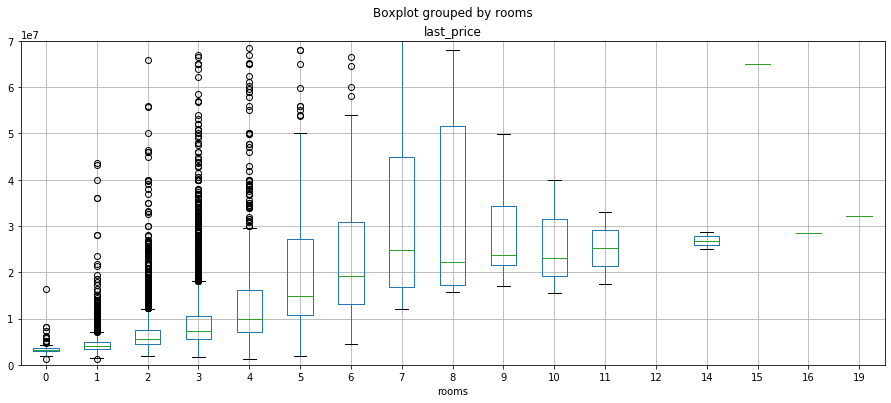

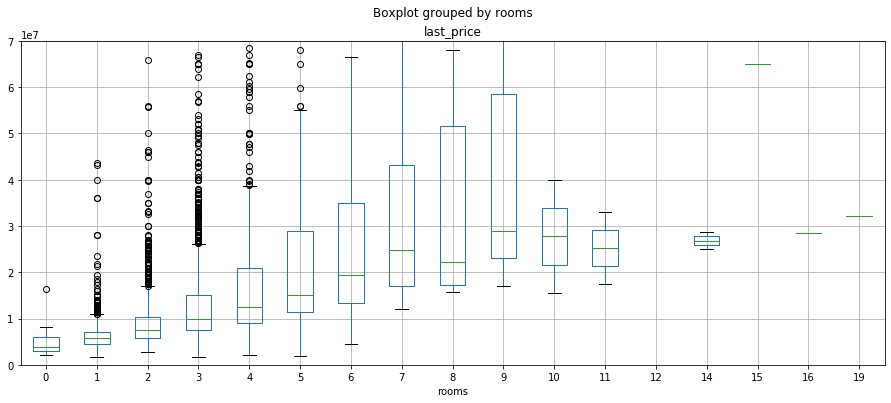

In [121]:
print(spb_data['rooms'].describe())
print(city_center['rooms'].describe())
spb_data.boxplot(column ='last_price',by ='rooms', figsize = (15,6))
plt.ylim(-50,70000000)
city_center.boxplot(column ='last_price',by ='rooms',figsize = (15,6))
plt.ylim(-50,70000000)

(-50, 20000000)

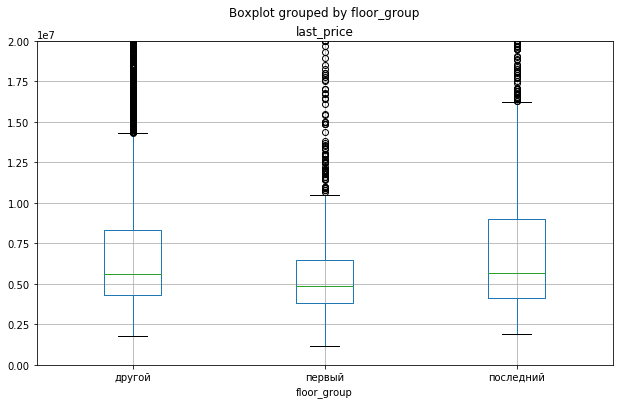

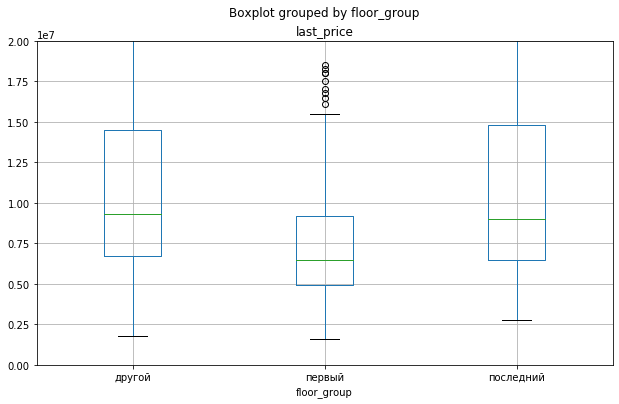

In [122]:
spb_data.boxplot(column ='last_price',by ='floor_group', figsize = (10,6))
plt.ylim(-50,20000000)
city_center.boxplot(column ='last_price',by ='floor_group',figsize = (10,6))
plt.ylim(-50,20000000)

(-50, 40000000)

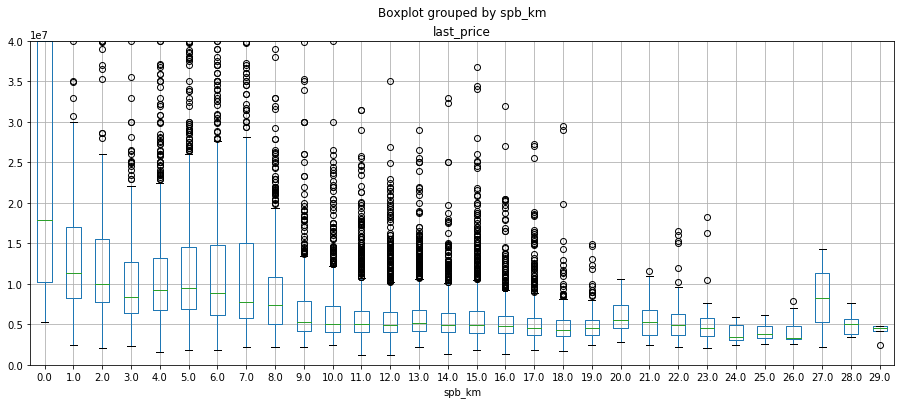

In [123]:
spb_data.boxplot(column ='last_price',by ='spb_km', figsize = (15,6))
plt.ylim(-50,40000000)

(-50, 35000000)

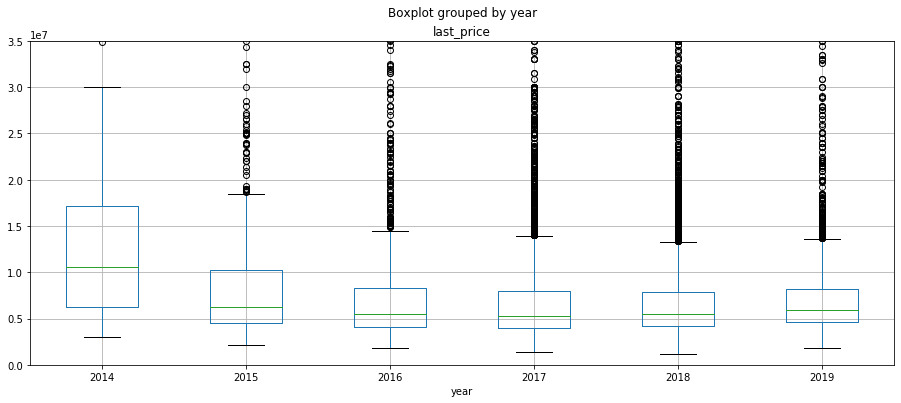

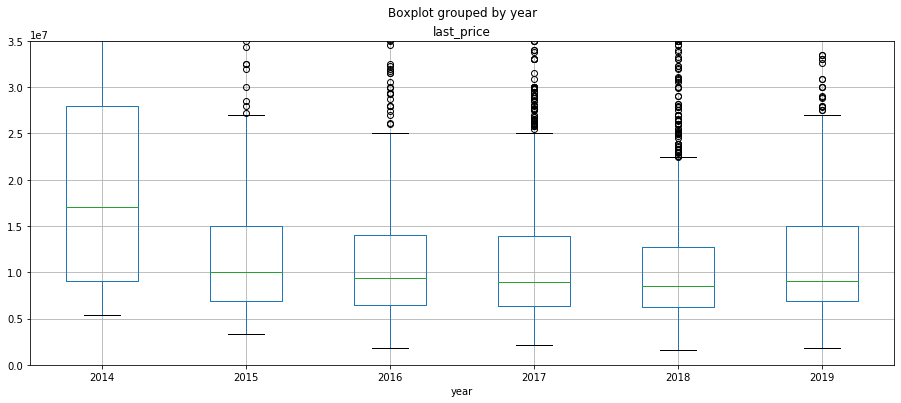

In [124]:
spb_data.boxplot(column ='last_price',by ='year', figsize = (15,6))
plt.ylim(-50,35000000)
city_center.boxplot(column ='last_price',by ='year',figsize = (15,6))
plt.ylim(-50,35000000)

(-50, 30000000)

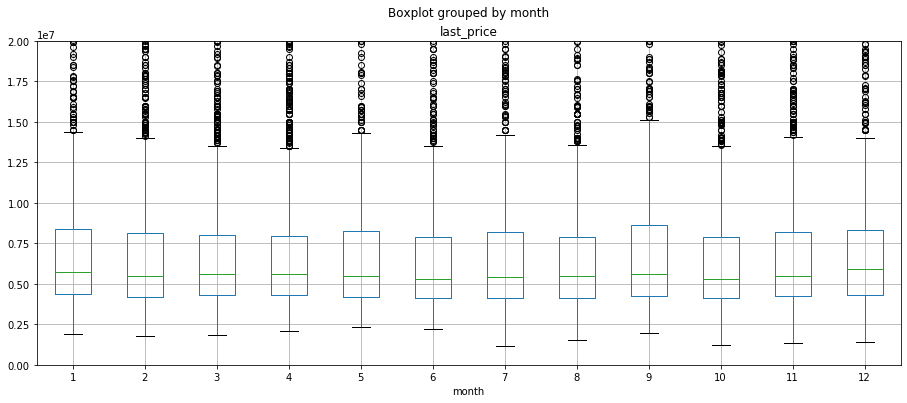

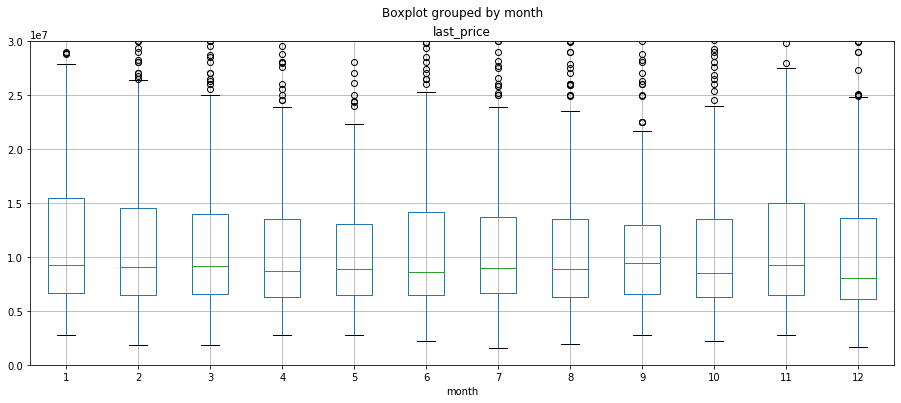

In [125]:
spb_data.boxplot(column ='last_price',by ='month', figsize = (15,6))
plt.ylim(-50,20000000)
city_center.boxplot(column ='last_price',by ='month',figsize = (15,6))
plt.ylim(-50,30000000)

(400000, 15000000)

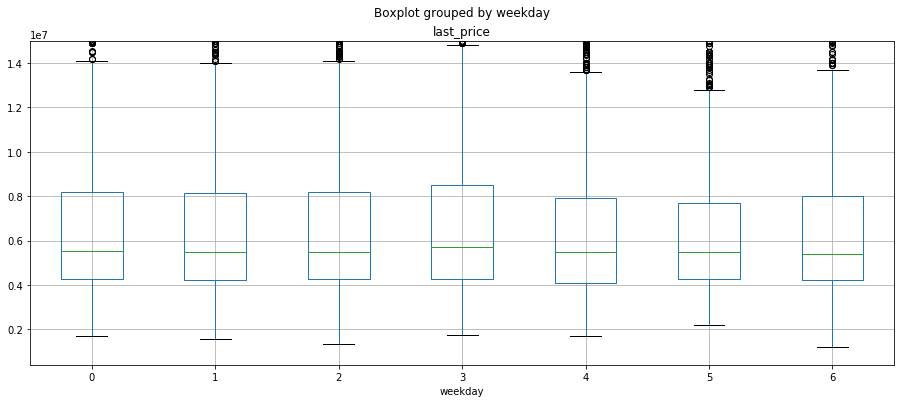

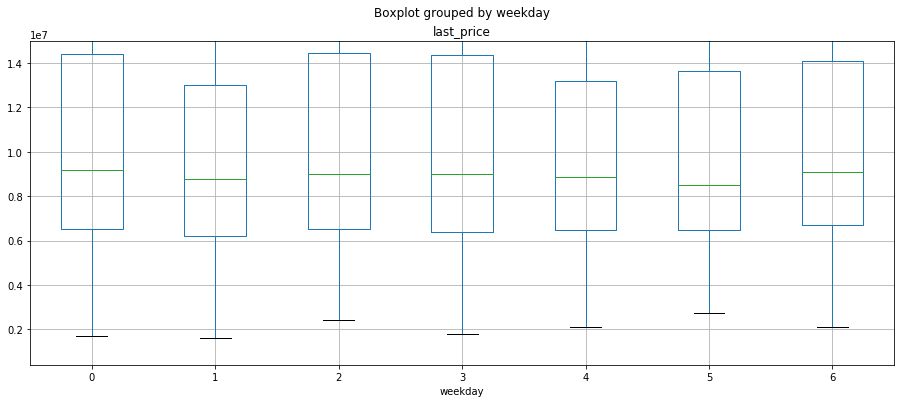

In [126]:
spb_data.boxplot(column ='last_price',by ='weekday', figsize = (15,6))
plt.ylim(400000,15000000)
city_center.boxplot(column ='last_price',by ='weekday',figsize = (15,6))
plt.ylim(400000,15000000)

* Если рассматривать зависимость изменения цены о числа комнат, то в среднем в центре города она такая же, как и по горду в целом, из тренда выбиваются только 9-ти и 10-ти комнатные картиры в центре.
* Зависимость изменения центы от этажа так же одинакова: что в центре, что по всему городу самая низкая стоимость у квартир на первом этаже, остальные квартиры (последний этаж или любой другой) продаются одинаково дороже.
* С зависимостью средней цены от удаленности от центра города мы уже разобрались: чем ближе к центру тем дороже, только после 9 километра эта зависимость почти полностью сглаживается.
* Если рассматривать зависимость от даты размещения, то как в общем выводе, так и в центре и по всему Санкт-Петербургу дороже всего продавались квартиры, объявления о продажи которых размещались в 2014 году. И вот зависимость от месяца публикации интересна тем, что квартиры выставленные в декабре продаются в центре города в среднем дешевле всего, а если смотреть по всему городу, не выделяя центр, то получается наоборот: выставленные в декабре квартиры продаются дороже. А вот особой разницы между днями недели не наблюдается. 

### Шаг 5. Общий вывод

##### Нашей задачей было научиться определять рыночную стоимость объектов недвижимости, и можно выделить следующие моменты:
1. Центром города можно счатать квартиры, расположенные в радиусе 8 киллометров, их средняя стоимость самая большая.
2. Самый большой фактор влияющий на стоимость это площадь квартиры: чем больше площадь, тем, соответственно, дороже квартира.
3. Следует обратить внимание на квартиры, срок продажи которых менее месяца, возможно имеет место мошенничество.
4. Большое количество пропущенных значений с информации о расстоянии от центра города: эти данные получены автоматически, следует обратить на это внимание и отладить заполнение данных.
5. Возможно следут ввести некторые ограничения для данных, заполняемых пользователем, что бы не выходило как с высотой полоков, где значения достигали 100м. Это позволит избежать аномалий.
6. Следует разробраться с аномальными показателями, когда большинсво квартир продаются за 45 и 60 дней, если предположение об ограничениях неактивных заявлений верно, то все в порядке, иначе это тоже похоже на мошенничество.